In [23]:
import pandas as pd
import geopandas as gpd

from acled_conflict_analysis import visuals
from acled_conflict_analysis import analysis

from datetime import datetime

import bokeh
from bokeh.models import Tabs, TabPanel
from bokeh.core.validation.warnings import EMPTY_LAYOUT, MISSING_RENDERERS
from bokeh.plotting import show, output_notebook

# Protests in Iran

We noticed from an initial analysis that there were more than 100 monthly protests in Iran consistently since 2016. This book goes deeper into the types of protests that took place. 

## Methodology

The Economists classified ~225 of the ACLED protests in Tehran into 6 different categroies. These categories were then used in a Large Language  Model (GPT3.5) t classify the rest of the ~25,000 protests

- Political/Security: Protests related to domestic and foreign political and security developments (excludes freedom/women /religious rights which are under the Social category).
- Livelihood (Prices, jobs and salaries): Protest against rising cost of living, lack of jobs, lack of adjustment of salaries and pensions to inflation
- Public service delivery: Lack of adequate/reliable access to electricity, water, security. 
- Business and legal: Potests related to companies (public and private), failing to meet obligations (e.g.,  delivery of products, etc.) and other legal restrictions or lack of their implementation.
- Climate and environment: Protest towards negative policie to the climate, biodiversity, animal treatment, etc.
- Social: Protests related to all social, religious issues (freedom of expression, women rights, etc.)

## Insights

The book organized the insights from the data. We looked at the change in protests over time, the geospatial spread of protests of different categories. 

### Change in protests over time


In [128]:
data = pd.read_csv('../../data/conflict/2012-01-01-2024-10-27-Iran.csv')

In [5]:
iran_adm0 = gpd.read_file(
    "../../data/boundaries/irn_admbnda_adm0_unhcr_20190514.shp")
iran_adm1 = gpd.read_file(
    "../../data/boundaries/irn_admbnda_adm1_unhcr_20190514.shp")
iran_adm2 = gpd.read_file(
    "../../data/boundaries/irn_admbnda_adm2_unhcr_20190514.shp")
iran_adm_all = gpd.read_file(
    "../../data/boundaries/irn_admbndl_admALL_unhcr_itos_20190514.shp")

In [129]:
protests_labelled = pd.read_csv('../../data/conflict/protests-labeled-all-gpt.csv')

In [16]:
protests = analysis.convert_to_gdf(protests_labelled[['event_date', 'latitude', 'longitude', 'classification', 'fatalities']])

In [131]:
analysis.data_type_conversion(protests_labelled)

In [21]:
protests_monthly = analysis.get_acled_by_group(protests_labelled, columns=['classification'], freq='MS')

In [ ]:
events_dict = {datetime(2022, 9,16):'Mahsa Amini\nDeath',
               
               datetime(2019,2,13):'Khash-Zahedan\nsuicide bombing',
               datetime(2022,10,26):'Shah Cherag\nMassacre',
               datetime(2019, 11,15):'Bloody Aban',
               datetime(2024, 1,3):'Kerman\nBombings',
               datetime(2020, 1,3): 'Qasem Soleimani\nAssassination'
               #datetime(2022, 10,5): 'West Azerbaijan\nEarthquake',
               }

In [27]:
output_notebook()
bokeh.core.validation.silence(EMPTY_LAYOUT, True)
bokeh.core.validation.silence(MISSING_RENDERERS, True)

tabs = []
titles = ["Number of conflict events"]

for idx, type in enumerate(["nrEvents"]):
    tabs.append(
        TabPanel(
            child=visuals.get_line_plot(
                protests_monthly,
                f"{titles[idx]} by province",
                f"Source: ACLED. Accessed {datetime.today().date()}",
                subtitle="",
                category="classification",
                measure=type,
                #events_dict=events_dict
            ),
            title=type.capitalize(),
        )
    )

tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)

Loading BokehJS ...

In [75]:
import numpy as np

p = pd.DataFrame(100*protests_monthly.groupby(['classification'])['nrEvents'].sum()/protests_monthly['nrEvents'].sum()).reset_index()
p.rename(columns={'nrEvents':"percentage of total protests"}, inplace=True)
p['percentage of total protests'] = np.round(p['percentage of total protests'],2)
p

,classification,percentage of total protests
0,Business and legal,13.50
1,Climate and environment,3.67
2,"Livelihood (Prices, jobs and salaries)",53.93
3,Political/Security,12.46
4,Public service delivery,3.94
5,Social,12.50


**Protests about livelihood i.e., prices, jobs and salaries constitute the greatest number of protests (~54%).** Climate and environmental protests are the lowest. However, we follow this up with a validation exercise to understand the peaks in the data by matching it with real world events. 

In [277]:
events_dict = {'Public service delivery':{datetime(2021, 7,15):'Water Protests',
               },
               'Political/Security':{datetime(2019,5,1):'Pro-Palestine protests marking Quds Days',
                                     datetime(2023,10,1):"Pro-Palestine Rally\nfollowing Insrael's first attack"},
               'Social':{datetime(2022, 9,16):'Mahsa Amini Death'},
               'Livelihood (Prices, jobs and salaries)':{datetime(2019, 11,15):'Bloody Aban',
                                                         datetime(2021,12,15):"Parliament adopts\nteachers' ranking bill"},
               'Climate and environment':{},
               'Business and legal':{datetime(2017,5,22):'Closing of Caspian Finance and Credit Institution'}}

In [278]:
from bokeh.plotting import show, output_notebook
import bokeh
from bokeh.core.validation.warnings import EMPTY_LAYOUT, MISSING_RENDERERS
from bokeh.models import Panel, Tabs, TabPanel

output_notebook()

bokeh.core.validation.silence(EMPTY_LAYOUT, True)
bokeh.core.validation.silence(MISSING_RENDERERS, True)

tabs = []
measure_names = {
    "nrEvents": "Number of Conflict Events"
}
measure_colors = {"nrEvents": "#4E79A7", "nrFatalities": "#F28E2B"}
# acled_adm0 = get_acled_by_admin(syria_adm2_crs, acled, columns = ['ADM2_EN', 'ADM1_EN'])
for category_type in list(protests_monthly["classification"].unique()):
    tabs.append(
        TabPanel(
            child=visuals.get_bar_chart(
                protests_monthly,
                f"Number of {category_type} Protests",
                f"Source: ACLED. Accessed date {datetime.today().date().isoformat()}",
                subtitle="",
                category="classification",
                measure="nrEvents",
                color_code=measure_colors["nrEvents"],
                category_value=category_type,
                events_dict=events_dict[category_type]
            ),
            title=category_type.title(),
        )
    )

tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)

Loading BokehJS ...

In [220]:
protests_labelled = analysis.convert_to_gdf(protests_labelled)
#protests_labelled.columns

In [227]:
protests_grouped = analysis.get_acled_by_group(protests_labelled, ['classification', 'admin2'])
#protests_grouped

In [228]:
protests_grouped.rename(columns={'admin2':'ADM2_EN'}, inplace=True)

In [229]:
protests_monthly_adm2 = iran_adm2[['ADM2_EN', 'geometry']].merge(protests_grouped)

In [262]:
protests_monthly_adm2['scaled_nrEvents'] = pd.qcut(protests_monthly_adm2['nrEvents'], q=3, labels=['Low', 'Medium', 'High'])
#protests_monthly_adm2['scaled_nrEvents'] = protests_monthly_adm2['scaled_nrEvents'].astype(int)

### Geospatial distribution of protests

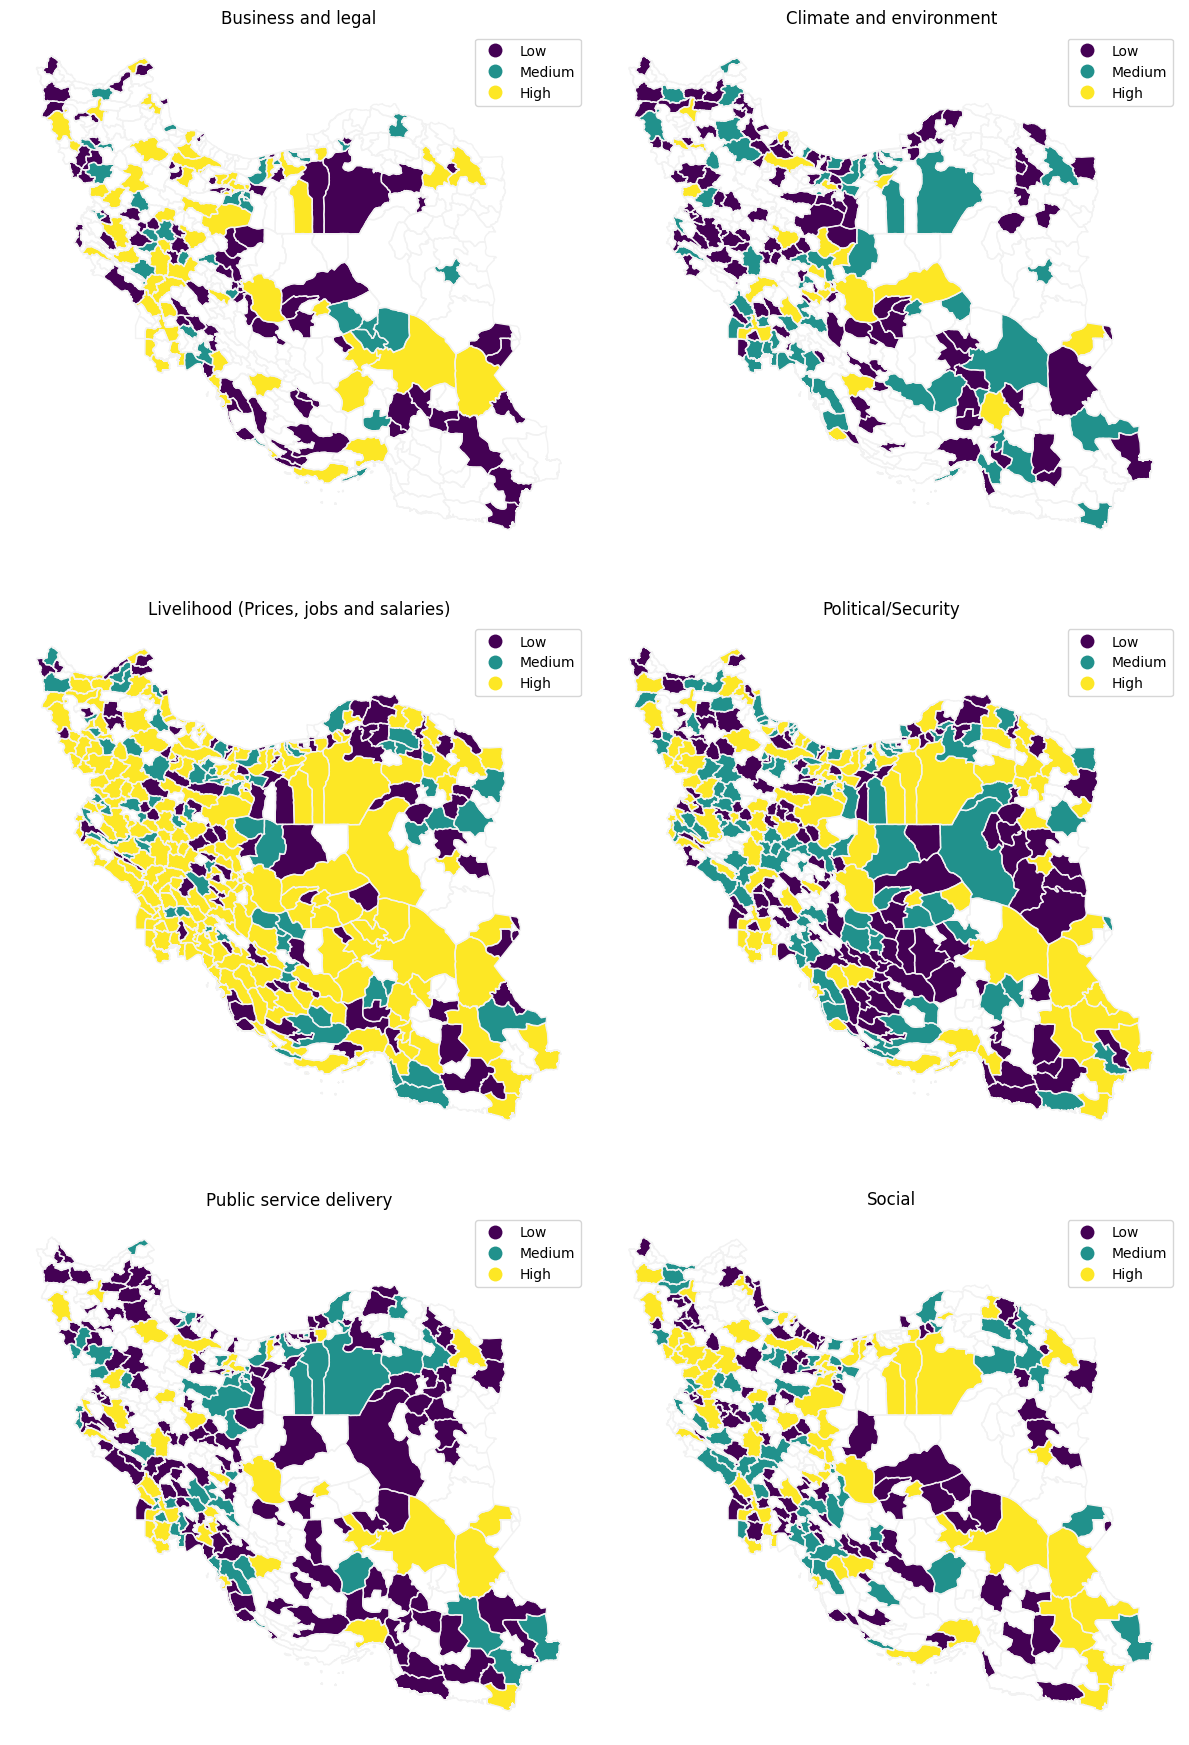

In [264]:
import matplotlib.pyplot as plt
# Create a figure with multiple subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 18))  # Adjust the layout and size as needed
axes = axes.flatten()  # Flatten axes array for easy iteration

classifications = protests_monthly_adm2['classification'].unique()

# Loop through each classification and corresponding subplot
for ax, classification in zip(axes, classifications):
    iran_adm2.boundary.plot(ax=ax, color='#f2f2f2', linewidth=1)
    
    # Plot the current classification
    protests_monthly_adm2[protests_monthly_adm2['classification'] == classification].plot(
        column='scaled_nrEvents', 
        legend=True, 
        cmap='viridis', 
        ax=ax
    )
    
    # Set title for each subplot
    ax.set_title(classification)
    
    # Remove spines (borders around the plot)
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    # Remove x-ticks and y-ticks
    ax.set_xticks([])
    ax.set_yticks([])

# Adjust the layout for better spacing
plt.tight_layout()
plt.show()

**There were significant number of protests in the 'Livelihood (Protests, jobs and salaries)' category across the country.** The other protests in 'Business and legal' and 'Climate and environment' were sporadic. The number events from 2016 to date were grouped into three categories based on percentile. The high-medium-low are categorized based on percentiles in each protest category. 

In [344]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import re
from collections import Counter
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()



def generate_word_cloud_from_column(df, column_name, custom_stopwords):
    # Combine all the text in the specified column into a single string
    text = " ".join(note for note in df[column_name])

    stopwords = set(STOPWORDS)
    if custom_stopwords:
        stopwords.update(custom_stopwords)  

    # Generate the word cloud
     # Generate the word cloud, excluding the stopwords
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color="white",
        stopwords=stopwords  # Pass the stopwords set here
    ).generate(text)


    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")  # Hide the axes
    plt.show()


def get_word_counts(df, column_name, custom_stopwords):

    text = " ".join(note for note in df[column_name])
    text = text.replace('salaries', 'salary')
    text = text.replace('retirees', 'retirement')
    text = text.replace('retired', 'retirement')

    words = re.findall(r'\b\w+\b', text.lower())

    wordcloud_stopwords = STOPWORDS
    all_stopwords = wordcloud_stopwords.union(custom_stopwords)
    all_stopwords_lower = {word.lower() for word in all_stopwords}

    # filtered_words = [word for word in words if word not in all_stopwords]
    # filtered_words = [word for word in words if word not in all_stopwords_lower and not word.isnumeric()]

    filtered_words_stemmed = [
    word for word in words 
    if word.lower() not in all_stopwords_lower and not word.isnumeric()
]


    # Step 2: Count the occurrences of each unique word
    word_counts = Counter(filtered_words_stemmed)

    # # Step 3: Prepare data for plotting
    # words = list(word_counts.keys())
    # frequencies = list(word_counts.values())

    word_count_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Count'])
    word_count_df = word_count_df.sort_values(by='Count', ascending=False)

    return word_count_df


month_names = [
    'January', 'February', 'March', 'April', 'May', 
    'June', 'July', 'August', 'September', 'October', 
    'November', 'December'
]

custom_stopwords = month_names + ['protest', 'protested', 'great', 'front', 
                    'rally', 'District Tehran', 'Tehran', 'group', 'District', 'held', 'Iran', 
                    'resident', 'residents', 'Isfahan', 'city', 's', 'local', 'khuzestan', 
                    'near', 'area', 'e', 'outside', 'demanding', 'months', 'county', 'staged',
                      'office', 'province', 'building', 'coordinating', 'organization', 'provincial',
                      'regarding', 'demand', 'central', 'ongoing', 'institution', 'support', 'ground', 'day',
                      'protesters', 'chants', 'slogans', 'friday', 'people', 'anti', 'rallied', 'chanting', 'recent'
                      , 'following', 'gathered', 'lack'] 
# Generate and display the word cloud from the 'notes' column


In [345]:
climate_words = get_word_counts(protests_labelled[(protests_labelled['classification']=='Climate and environment')], 'notes', custom_stopwords)
livelihood_words = get_word_counts(protests_labelled[(protests_labelled['classification']=='Livelihood (Prices, jobs and salaries)')], 'notes', custom_stopwords)
business_words = get_word_counts(protests_labelled[(protests_labelled['classification']=='Business and legal')], 'notes', custom_stopwords)
political_words = get_word_counts(protests_labelled[(protests_labelled['classification']=='Political/Security')], 'notes', custom_stopwords)
social_words = get_word_counts(protests_labelled[(protests_labelled['classification']=='Social')], 'notes', custom_stopwords)
public_service_words = get_word_counts(protests_labelled[(protests_labelled['classification']=='Public service delivery')], 'notes', custom_stopwords)

In [386]:
import matplotlib.pyplot as plt
import numpy as np

def create_waffle_chart(data, rows=10, cols=10, cmap_name='tab10', chart_title=None):
    """
    Create a waffle chart using matplotlib.

    Parameters:
    - data: Dictionary of category names and their values
    - rows: Number of rows in the waffle chart grid
    - cols: Number of columns in the waffle chart grid
    - cmap_name: Name of the matplotlib colormap to use for the chart
    """
    total_values = sum(data.values())
    total_squares = rows * cols

    # Calculate the number of squares for each category
    squares_per_category = {category: int(value / total_values * total_squares) for category, value in data.items()}

    # Create the waffle chart grid
    waffle_grid = np.zeros((rows, cols))

    # Fill the grid with category values
    category_index = 0
    categories = list(squares_per_category.keys())
    values = list(squares_per_category.values())

    for row in range(rows):
        for col in range(cols):
            if values[category_index] > 0:
                waffle_grid[row, col] = category_index + 1
                values[category_index] -= 1
            else:
                category_index += 1
                if category_index < len(values):
                    waffle_grid[row, col] = category_index + 1

    # Plot the waffle chart
    plt.figure(figsize=(10, 6))
    cmap = plt.get_cmap(cmap_name, len(categories))
    plt.matshow(waffle_grid, cmap=cmap, fignum=1)

    # Add legend
    colors = [cmap(i) for i in range(len(categories))]
    labels = [f"{category} ({data[category]})" for category in categories]
    patches = [plt.Rectangle((0, 0), 1, 1, color=colors[i]) for i in range(len(categories))]
    plt.legend(patches, labels, loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=len(categories)/3, frameon=False)

    plt.title(chart_title)
    plt.axis('off')
    #plt.show()

    plt.savefig(f'../../docs/images/{chart_title}_words.png')


In [394]:
# create_waffle_chart(public_service_words.head(15).set_index('Word').to_dict()['Count'], rows=20, cols=40, cmap_name='viridis'
#                     , chart_title='Public services')


In [397]:
# import os

# def generate_markdown(folder_path):
#     """
#     Generate and print Markdown for images in the specified folder using a tab-set format.

#     Parameters:
#     - folder_path: Path to the folder containing the images
#     """
#     # Get all image files from the folder
#     image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

#     # Start the tab-set block
#     print("::::{tab-set}")
    
#     for image_file in sorted(image_files):
#         # Extract date or relevant information from the filename
#         # Assuming filename format like 'fatalities_2023-04-01.png'
#         date_part = image_file.split('_')[1].split('.')[0] if '_' in image_file else image_file.split('.')[0]

#         # Print each tab-item block
#         print(f"::{{tab-item}} {date_part}")
#         print(f"![{image_file}](../../docs/images/conflict/{image_file})")
#         print(":::")
#     # End the tab-set block
#     print("::::")

# # Example usage
# folder_path = '../../docs/images/words/'
# generate_markdown(folder_path)


::::{tab-set}
:::{tab-item} business and legal
![Business_and_legal_words.png](../../docs/images/words/Business_and_legal_words.png)
:::
:::{tab-item} climate and environment
![Climate_and_environment_words.png](../../docs/images/words/Climate_and_environment_words.png)
:::
:::{tab-item} livelihood (prices, jobs and salaries)
![Livelihood_words.png](../../docs/images/words/Livelihood_words.png)
:::
:::{tab-item} political/security
![Political_words.png](../../docs/images/words/Political_words.png)
:::
:::{tab-item} public services
![Public_services_words.png](../../docs/images/words/Public_services_words.png)
:::
:::{tab-item} social
![Social_words.png](../../docs/images/words/Social_words.png)
:::
::::